%load_ext autoreload
%autoreload 2

In [ ]:
import os, sys
import dask.dataframe as dd

root_path = r'C:\KonaAI ML\konaai_ml-3.2.5\code'
if root_path not in sys.path:
    sys.path.append(root_path)

# Prepare Alerts Data

In [ ]:
import pandas as pd
from IPython.display import display
from src.utils.db_mgmt import DBHandler

alerts_query = 'SELECT AH.AlertId, AH.EntityID, AH.Module, AH.SubModule, SL.StatusDescription, AD.SPT_RowID, AD.UDMTable, QR.ResponseText, QR.[QuestionnaireAssID] AS QTAID, QT.QuestionnaireText, QT.Options, QT.RenderTypeID \
FROM app.AlertHeader AS AH \
INNER JOIN ref.StatusLookup AS SL ON SL.[StatuslookupId] = AH.AlertState \
INNER JOIN App.AlertDetails AS AD ON AD.[AlertId] = AH.AlertId \
INNER JOIN App.[QuestionnaireResponse] AS QR ON QR.[AlertId] = AH.AlertId \
INNER JOIN App.[QuestionnaireTemplateAssociation] AS QTA ON QTA.[QuestionnaireTemplateAssociationID] = QR.[QuestionnaireAssID] \
INNER JOIN App.Questionnaire AS QT ON QT.[QuestionnaireID] = QTA.QuestionnaireID \
where AH.isSoftDelete = 0 and QR.IsActive = 1 and QTA.IsActive = 1 and QT.IsActive = 1'



dbhandle = DBHandler()
dbhandle.set_connection_string(instance_db=True, instance_id='1af3a36a-0184-4bda-aad2-a0066bfb77f1')
alerts_data = dbhandle.download_table_or_query(query=alerts_query)
alerts_data = pd.read_parquet(alerts_data)
alerts_data = alerts_data[alerts_data['StatusDescription'] == 'Closed']
print('Total closed alerts', len(alerts_data))
display(alerts_data.head())

In [ ]:
alerts_data = alerts_data[alerts_data['QuestionnaireText'] == '3c. Alert Determination']
alerts_data = alerts_data[['AlertId','Module', 'SubModule', 'StatusDescription', 'SPT_RowID', 'ResponseText']].drop_duplicates()
display(alerts_data)

In [ ]:
print('Total Closed Alerts', alerts_data['AlertId'].nunique())

print('Total Alerts By Submodule and response')
display(alerts_data.groupby(['Module', 'SubModule', 'ResponseText'])['AlertId'].nunique())

print('Total Transactions By Submodule and response')
display(alerts_data.groupby(['Module', 'SubModule', 'ResponseText'])['SPT_RowID'].nunique())

In [ ]:
concern_keys = ['Concern']
non_concern_keys = ['No Concern']

In [ ]:
import numpy as np
alerts_data['target'] = np.where(alerts_data['ResponseText'].isin(concern_keys), 1, 0)
alerts_data

In [ ]:
alerts_data['ResponseText'].value_counts()

In [ ]:
alerts_data['target'].value_counts()

In [ ]:
alerts_data[alerts_data['ResponseText']=='Concern']

In [ ]:
payments_ids = alerts_data[alerts_data['SubModule'] == 'Payments']
invoice_ids = alerts_data[alerts_data['SubModule'] == 'Invoices']
po_ids = alerts_data[alerts_data['SubModule'] == 'Purchase Orders']
display(payments_ids)

# Prepare Training Data

In [ ]:
data_table = '[Analytics].[VendorMaster_x_Invoices_x_Payments_x_GLAccounts]'
query = f"select * from {data_table} where PMT_SPT_RowID in ({','.join([str(id) for id in payments_ids['SPT_RowID'].unique().tolist()])})"
query

In [ ]:
df_path = dbhandle.download_table_or_query(query=query)
df = dd.read_parquet(df_path)
df.head()

In [ ]:
X = df.merge(payments_ids[['SPT_RowID', 'target']], left_on='PMT_SPT_RowID', right_on='SPT_RowID', suffixes=('','_y'))
display(X.head(5))

In [ ]:
X.to_parquet(r'C:\KonaAI ML\konaai_ml-3.2.5\code\temp\data.parquet')

# Create prediction Transformer

In [1]:
import contextlib
import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List
import pandas as pd
import numpy as np
import dask.dataframe as dd
import inspect
import traceback

class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nans = [None, np.nan, 'nan', 'other', ""]

    def _eval_value(self, value_str):
        # check if string else return
        if not isinstance(value_str, str):
            return value_str

        value_str = value_str.strip()
        # Try converting to Boolean
        if value_str.lower() == 'true':
            return True
        elif value_str.lower() == 'false':
            return False

        # Try converting to int
        with contextlib.suppress(ValueError):
            return int(value_str)
        # Try converting to float
        with contextlib.suppress(ValueError):
            return float(value_str)
        # Try converting to datetime
        date_formats = ["%Y-%m-%d", "%Y-%m-%d %H:%M:%S", "%Y-%m-%dT%H:%M:%S"]
        for date_format in date_formats:
            with contextlib.suppress(ValueError):
                return datetime.datetime.strptime(value_str, date_format)
        # If none of the conversions work, return the original string
        return value_str

    def _flag_invalid_date(self, x):
        x = self._eval_value(x)
        return 0 if isinstance(x, datetime.datetime) else 1
        
    def _flag_zero(self, x):
        try:
            return 0 if self._eval_value(x) > 0 else 1
        except Exception as _e:
            print(x, type(x), _e)
            traceback.print_exc()
            return 1
        
    def _flag_if_nan(self, x):
        return 1 if x in self.nans else 0
        
    def _flag_if_value(self, x):
        """ Return 1 if value is not nan or not zero"""
        x = self._eval_value(x)
        if isinstance(x, (int, float)):
            return 1 if x > 0 else 0
        return 1 if x not in self.nans else 0

    def _flag_false(self, x):
        try:
            return 1 if self._eval_value(x) == False else 0
        except Exception as _e:
            print(x, type(x), _e)
            traceback.print_exc()
            return 0

    def _flag_true(self, x):
        try:
            return 1 if self._eval_value(x) == True else 0
        except Exception as _e:
            print(x, type(x), _e)
            traceback.print_exc()
            return 0

    def run(self, _df: pd.DataFrame):
        input_columns = _df.columns

        _df['RoundAmountInvoice'] = _df['FMP2P001'].fillna('No Round Amount').apply(lambda x: 0 if x == 'No Round Amount' else 1)
        _df['ValidInvoiceDescription'] = _df['InvoiceDescription'].fillna("").apply(self._flag_if_nan)
        _df['ValidPaymentTerms'] = _df['PaymentTerms'].fillna("").apply(self._flag_if_nan) 
        _df['ValidInvoiceVendorCurrency'] = _df['InvoiceVendorCurrency'].fillna("").apply(self._flag_if_nan) 
        _df['DuplicateInvoiceFMP2P006'] = pd.to_numeric(_df['FMP2P006']).fillna(0).apply(self._flag_if_value)
        _df['SingleInvoiceVendor'] = _df['FMP2P014'].apply(self._eval_value).fillna(False).apply(self._flag_true)
        _df['CreditDebit'] = _df['InvoiceDebitOrCreditIndicator'].fillna('H-Credit').apply(lambda x: 0 if x == 'H-Credit' else 1)
        _df['ValidPaymentDate'] = _df['PaymentDate'].apply(self._flag_invalid_date) 
        _df['ValidPaymentMethod'] = _df['PaymentMethod'].apply(self._flag_if_nan) 
        _df['ValidVendorTaxID'] = _df['VendorTaxID'].apply(self._flag_if_nan)
        _df['ValidInvoiceAuthorizedDate'] = _df['InvoiceAuthorizedDate'].apply(self._flag_invalid_date)
        _df['ValidPaymentInvoiceDate'] = _df['PaymentInvoiceDate'].apply(self._flag_invalid_date) 
        _df['DifferentVendorPayee'] = _df['FMP2P029'].fillna(False).apply(self._flag_true)
        _df['InvoiceTestsHits'] = _df['INV_Tests_Failed_Count'].apply(self._flag_if_value)
        _df['ValidInvoicePaymentDate'] = _df['InvoicePaymentDate'].apply(self._flag_invalid_date) 
        _df['TestsFailedCount'] = _df['TestsFailedCount'].apply(self._flag_if_value)
        _df['DifferentPaymentCurrencyForVendor'] = _df['FMP2P032'].fillna(False).apply(self._flag_true)
        _df['ValidBankBranch'] = _df['BankBranch'].apply(self._flag_if_nan)
        _df['ValidPaymentCompanyCode'] = _df['PaymentCompanyCode'].apply(self._flag_if_nan) 
        _df['ValidPaymentDescription'] = _df['PaymentDescription'].apply(self._flag_if_nan)
        _df['ValidVendorCountry'] = _df['VendorCountry'].apply(self._flag_if_nan) 
        _df['SinglePaymentVendor'] = _df['FMP2P026'].fillna(False).apply(self._flag_true)
        _df['ValidPayeeName'] = _df['PMT_SPT_PayeeName'].apply(self._flag_if_nan) 
        _df['ValidPaymentStatus'] = _df['PaymentStatus'].apply(self._flag_if_nan)
        _df['ValidScheduledPayDate'] = _df['ScheduledPayDate'].apply(self._flag_invalid_date)
        _df['ValidInvoiceCountry'] = _df['InvoiceCountry'].fillna("").apply(self._flag_if_nan)
        _df['ValidInvoiceDate'] = _df['InvoiceDate'].apply(self._flag_invalid_date) 
        _df['DuplicateInvoiceFMP2P007'] = pd.to_numeric(_df['FMP2P007']).fillna(0).apply(self._flag_if_value)
        _df['ValidRemitCountry'] = _df['RemitCountry'].apply(self._flag_if_nan) 
        _df['DuplicatePaymentFMP2P039'] = _df['FMP2P039'].apply(self._flag_if_value)
        _df['InvoiceOnHoliday'] = _df['FMP2P018'].fillna('Working Day').apply(lambda x: 1 if x != 'Working Day' else 0)
        _df['ValidPayeeName'] = _df['PayeeName'].apply(self._flag_if_nan) 
        _df['ValidPaymentCreatedDate'] = _df['PaymentCreatedDate'].apply(self._flag_invalid_date) 
        _df['ValidPaymentCurrencyCode'] = _df['PaymentCurrencyCode'].apply(self._flag_if_nan) 
        _df['NonMasterVendorInvoice'] = _df['FMP2P012'].apply(self._eval_value).fillna(False).apply(self._flag_true)
        _df['ValidBankAccount'] = _df['BankAccount'].apply(self._flag_if_nan)
        _df['KeywordInPaymentDesc'] = _df['FMP2P033'].apply(self._flag_if_value) 
        _df['ValidVendorCategory'] = _df['VendorCategory'].apply(self._flag_if_nan)
        _df['ValidPaymentApprovedDate'] = _df['PaymentApprovedDate'].apply(self._flag_invalid_date) 
        _df['OutlierPayment'] = _df['FMP2P040'].fillna(False).apply(self._flag_true)
        _df['ValidPaymentFiscalYear'] = _df['PaymentFiscalYear'].apply(self._flag_if_nan) 
        _df['RoundAmountPayment'] = _df['FMP2P022'].apply(lambda x: 0 if x == 'No Round Amount' else 1)
        _df['ValidInvoiceFiscalYear'] = _df['InvoiceFiscalYear'].fillna("").apply(self._flag_if_nan) 
        _df['ValidPaymentClearedDate'] = _df['PaymentClearedDate'].apply(self._flag_invalid_date) 
        _df['ValidPaymentTermDescription'] = _df['PaymentTermDescription'].apply(self._flag_if_nan)
        _df['PaymentTestHits'] = _df['PMT_Tests_Failed_Count'].apply(self._flag_if_value)
        _df['ValidPaymentDueDate'] = _df['PaymentDueDate'].apply(self._flag_invalid_date) 
        _df['PaymentOnHoliday'] = _df['FMP2P021'].apply(lambda x: 1 if x != 'Working Day' else 0)
        _df['ValidInvoiceCapturedOn'] = _df['InvoiceCapturedOn'].apply(self._flag_invalid_date) 
        _df['ValidInvoiceCompanyCode'] = _df['InvoiceCompanyCode'].fillna("").apply(self._flag_if_nan) 
        _df['SequentialInvoiceNumber'] = pd.to_numeric(_df['FMP2P016']).fillna(0).apply(self._flag_if_value)
        _df['OutlierInvoice'] = _df['FMP2P013'].apply(self._eval_value).fillna(False).apply(self._flag_true)
        _df['ValidInvoiceType'] = _df['InvoiceType'].fillna("").apply(self._flag_if_nan) 

        added_columns = _df.columns.difference(input_columns)

        print("New Features")
        print(added_columns)

        return _df[added_columns]

    def fit(self):
        return self

    def transform(self, X: dd.DataFrame):
        return X.map_partitions(self.run, meta=X)

In [2]:
input_columns = ['FMP2P001',
'InvoiceDescription',
'PaymentTerms',
'InvoiceVendorCurrency',
'FMP2P006',
'FMP2P014',
'InvoiceDebitOrCreditIndicator',
'PaymentDate',
'PaymentMethod',
'VendorTaxID',
'InvoiceAuthorizedDate',
'PaymentInvoiceDate',
'FMP2P029',
'INV_Tests_Failed_Count',
'InvoicePaymentDate',
'TestsFailedCount',
'FMP2P032',
'BankBranch',
'PaymentCompanyCode',
'PaymentDescription',
'VendorCountry',
'FMP2P026',
'PMT_SPT_PayeeName',
'PaymentStatus',
'ScheduledPayDate',
'InvoiceCountry',
'InvoiceDate',
'FMP2P007',
'RemitCountry',
'FMP2P039',
'FMP2P018',
'PayeeName',
'PaymentCreatedDate',
'PaymentCurrencyCode',
'FMP2P012',
'BankAccount',
'FMP2P033',
'VendorCategory',
'PaymentApprovedDate',
'FMP2P040',
'PaymentFiscalYear',
'FMP2P022',
'InvoiceFiscalYear',
'PaymentClearedDate',
'PaymentTermDescription',
'PMT_Tests_Failed_Count',
'PaymentDueDate',
'FMP2P021',
'InvoiceCapturedOn',
'InvoiceCompanyCode',
'FMP2P016',
'FMP2P013',
'InvoiceType']

# Prepare Data for Modelling

In [3]:
input_file_path = r'C:\KonaAI ML\konaai_ml-3.2.5\code\temp\data.parquet'

import pandas as pd
import numpy as np

df = pd.read_parquet(input_file_path)
df = df.reset_index(drop=True)
df = df.drop_duplicates()
print(f"Input data shape: {df.shape}")

df.info(verbose=True)

Input data shape: (2615, 522)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 522 columns):
 #    Column                                Dtype               
---   ------                                -----               
 0    VendorNumber                          string              
 1    VendorCompanyCode                     string              
 2    VendorName                            string              
 3    VendorType                            string              
 4    VendorCategory                        string              
 5    VendorCreatedDate                     date32[day][pyarrow]
 6    VendorActiveDate                      date32[day][pyarrow]
 7    VendorInactiveDate                    date32[day][pyarrow]
 8    VendorSSN                             string              
 9    VendorTaxID                           string              
 10   VendorStatus                          string              
 11   VendorCount

In [4]:
# Assuming you have your data and labels
y = df['target'].reset_index(drop=True)

# in case y variable values are string, convert to numeric
if isinstance(y.iloc[0], str):
    y = y.apply(lambda x: eval(x))

print([type(x) for x in y.unique()])
print(y.value_counts())

[<class 'numpy.int32'>, <class 'numpy.int32'>]
target
0    2595
1      20
Name: count, dtype: int64


In [5]:
feature_transformer = FeatureTransformer()
X = feature_transformer.run(df).reset_index(drop=True)

X['target'] = y.values

print(f"Transformed data shape: {X.shape}")
# X.info(verbose=True)

New Features
Index(['CreditDebit', 'DifferentPaymentCurrencyForVendor',
       'DifferentVendorPayee', 'DuplicateInvoiceFMP2P006',
       'DuplicateInvoiceFMP2P007', 'DuplicatePaymentFMP2P039',
       'InvoiceOnHoliday', 'InvoiceTestsHits', 'KeywordInPaymentDesc',
       'NonMasterVendorInvoice', 'OutlierInvoice', 'OutlierPayment',
       'PaymentOnHoliday', 'PaymentTestHits', 'RoundAmountInvoice',
       'RoundAmountPayment', 'SequentialInvoiceNumber', 'SingleInvoiceVendor',
       'SinglePaymentVendor', 'ValidBankAccount', 'ValidBankBranch',
       'ValidInvoiceAuthorizedDate', 'ValidInvoiceCapturedOn',
       'ValidInvoiceCompanyCode', 'ValidInvoiceCountry', 'ValidInvoiceDate',
       'ValidInvoiceDescription', 'ValidInvoiceFiscalYear',
       'ValidInvoicePaymentDate', 'ValidInvoiceType',
       'ValidInvoiceVendorCurrency', 'ValidPayeeName',
       'ValidPaymentApprovedDate', 'ValidPaymentClearedDate',
       'ValidPaymentCompanyCode', 'ValidPaymentCreatedDate',
       'ValidPayme

In [6]:
import pandas as pd

# Calculate the correlation matrix
correlation_matrix = X.corr()

# Exclude self-correlations and duplicate entries
correlation_matrix = correlation_matrix.mask(
    np.tril(np.ones(correlation_matrix.shape)).astype(bool))

# Flatten the correlation matrix into a series
correlation_series = correlation_matrix.stack()

# Sort the correlation values in descending order
sorted_correlation_series = correlation_series.sort_values(ascending=False)

# Print the pairs of variables with the highest correlation values
correlation_threshold = .8  # Change this value to print more or fewer pairs
sorted_correlation_series : pd.Series = sorted_correlation_series[abs(sorted_correlation_series) > correlation_threshold]

for (var1, var2), correlation in sorted_correlation_series.items():
    # correlation against target
    if any([var1 == 'target', var2 == 'target']):
        continue

    target_correlation1 = round(correlation_matrix.loc[var1, 'target'], 3)
    target_correlation2 = round(correlation_matrix.loc[var2, 'target'], 3)

    print(f"{var1}:({target_correlation1}) and {var2}:({target_correlation2}) = {correlation:.2f}")

ValidInvoiceCompanyCode:(-0.036) and ValidInvoiceVendorCurrency:(-0.036) = 1.00
ValidInvoiceCompanyCode:(-0.036) and ValidInvoiceType:(-0.036) = 1.00
ValidInvoiceType:(-0.036) and ValidInvoiceVendorCurrency:(-0.036) = 1.00
ValidInvoiceCountry:(-0.036) and ValidInvoiceVendorCurrency:(-0.036) = 1.00
ValidInvoiceCountry:(-0.036) and ValidInvoiceType:(-0.036) = 1.00
ValidInvoiceCountry:(-0.036) and ValidInvoiceFiscalYear:(-0.036) = 1.00
ValidInvoiceFiscalYear:(-0.036) and ValidInvoiceVendorCurrency:(-0.036) = 1.00
ValidInvoiceFiscalYear:(-0.036) and ValidInvoiceType:(-0.036) = 1.00
ValidInvoiceCompanyCode:(-0.036) and ValidInvoiceFiscalYear:(-0.036) = 1.00
ValidPaymentTermDescription:(-0.01) and ValidPaymentTerms:(-0.01) = 1.00
ValidInvoiceCompanyCode:(-0.036) and ValidInvoiceCountry:(-0.036) = 1.00


In [9]:
from IPython.display import HTML

# Calculate the correlation matrix
correlation_matrix = X.corr().abs()
target_correlation = correlation_matrix['target'].abs()

# drop the Target column
correlation_matrix = correlation_matrix.drop('target', axis=1)
# drop Target row
correlation_matrix = correlation_matrix.drop('target', axis=0)

high_corr_features = []
for col in correlation_matrix.columns:
    corr_sum = correlation_matrix[col].sum()
    t_corr = target_correlation[col]
    result = corr_sum/t_corr
    high_corr_features.append((col, result))

high_corr_features = sorted(high_corr_features, key=lambda x: x[1], reverse=True)
# create a dataframe
high_corr_features_df = pd.DataFrame(high_corr_features, columns=['feature', 'sum_corr'])
high_corr_features_df = high_corr_features_df.dropna().sort_values
display(high_corr_features_df)

<bound method DataFrame.sort_values of                         feature    sum_corr
1      DuplicateInvoiceFMP2P007  504.430658
2      DuplicatePaymentFMP2P039  260.963070
6           SingleInvoiceVendor  256.604989
7           SinglePaymentVendor  150.882086
8            RoundAmountPayment   76.201055
13      ValidInvoiceCompanyCode  235.574799
14          ValidInvoiceCountry  235.574799
16      ValidInvoiceDescription  440.319646
17       ValidInvoiceFiscalYear  235.574799
18               OutlierInvoice  160.293701
19      SequentialInvoiceNumber  108.679907
20               OutlierPayment   39.837230
21              PaymentTestHits   13.440834
23             ValidInvoiceType  235.574799
24   ValidInvoiceVendorCurrency  235.574799
25                  CreditDebit  228.344496
26             InvoiceTestsHits  193.891449
27             InvoiceOnHoliday  143.937968
28           RoundAmountInvoice  100.295087
29     DuplicateInvoiceFMP2P006   87.860908
30         DifferentVendorPayee   47.

In [10]:
X = X.drop('target', axis=1).reset_index(drop=True)

# in case y variable values are string, convert to numeric
if isinstance(y.iloc[0], str):
    y = y.apply(lambda x: eval(x))

print([type(x) for x in y.unique()])
print(y.value_counts())

[<class 'numpy.int32'>, <class 'numpy.int32'>]
target
0    2595
1      20
Name: count, dtype: int64


In [138]:
# import sweetviz as sv

# my_report = sv.analyze(X)
# my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

In [11]:
from sklearn.model_selection import train_test_split

# Set the test size and validation size as a percentage of your data
test_size = 0.2  # 20% of the data for testing
validation_size = 0.2  # 20% of the data for validation

# Calculate the number of samples for test and validation based on the class distribution
class_counts = np.bincount(y)
num_minority_class = np.min(class_counts)
num_majority_class = np.max(class_counts)

test_size_minority = int(test_size * num_minority_class)
validation_size_minority = int(validation_size * num_minority_class)

test_size_majority = int(test_size * num_majority_class)
validation_size_majority = int(validation_size * num_majority_class)

minority_indices = y[y == 1].index
majority_indices = y[y == 0].index

# Split the data into minority and majority classes
X_minority = X.iloc[minority_indices]
X_majority = X.iloc[majority_indices]
y_minority = y[y == 1]
y_majority = y[y == 0]


# Split the minority class into train, test, and validation sets
X_minority_train, X_minority_temp, y_minority_train, y_minority_temp = train_test_split(
    X_minority, y_minority, test_size=(test_size_minority + validation_size_minority), stratify=y_minority)

# Split the majority class into train, test, and validation sets
X_majority_train, X_majority_temp, y_majority_train, y_majority_temp = train_test_split(
    X_majority, y_majority, test_size=(test_size_majority + validation_size_majority), stratify=y_majority)

# Combine the minority and majority class splits to get the final train, test, and validation sets
X_train = np.vstack((X_minority_train, X_majority_train))
y_train = np.concatenate((y_minority_train, y_majority_train))

X_temp = np.vstack((X_minority_temp, X_majority_temp))
y_temp = np.concatenate((y_minority_temp, y_majority_temp))

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=validation_size / (test_size + validation_size), stratify=y_temp)

# Now, X_train, y_train, X_test, y_test, X_val, y_val contain the respective splits.
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1569, 51)
y_train shape: (1569,)
X_test shape: (523, 51)
y_test shape: (523,)


In [12]:
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import precision_score, recall_score
from IPython.display import HTML

# Define custom metrics functions
def custom_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='binary')

def custom_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average='binary')

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=custom_recall)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# Convert the LazyPredict output to an HTML table
html_table = models.to_html(classes='table table-striped table-bordered', justify='center')

HTML(html_table)

100%|██████████| 29/29 [00:01<00:00, 15.82it/s]

[LightGBM] [Info] Number of positive: 12, number of negative: 1557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007648 -> initscore=-4.865610
[LightGBM] [Info] Start training from score -4.865610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,custom_recall,Time Taken
Model,,,,,,
KNeighborsClassifier,0.98,0.99,0.99,0.99,1.00,0.14
PassiveAggressiveClassifier,0.97,0.99,0.99,0.98,1.00,0.02
GaussianNB,0.65,0.82,0.82,0.78,1.00,0.01
Perceptron,0.99,0.75,0.75,0.99,0.50,0.01
LinearDiscriminantAnalysis,0.97,0.74,0.74,0.98,0.50,0.02
NearestCentroid,0.97,0.74,0.74,0.98,0.50,0.02
AdaBoostClassifier,0.99,0.50,0.50,0.99,0.00,0.15
XGBClassifier,0.99,0.50,0.50,0.99,0.00,0.07
SVC,0.99,0.50,0.50,0.99,0.00,0.02


Average Validation F1 Score: 0.42
Standard Deviation of Validation F1 Score: 0.33
Feature ranking:
1. OutlierPayment (0.2841)
2. DifferentVendorPayee (0.2795)
3. PaymentTestHits (0.1581)
4. InvoiceTestsHits (0.1537)
5. ValidInvoiceDescription (0.0728)
6. ValidInvoiceType (0.0080)
7. SinglePaymentVendor (0.0054)
8. ValidInvoiceCountry (0.0052)
9. RoundAmountPayment (0.0052)
10. ValidInvoiceFiscalYear (0.0048)
11. RoundAmountInvoice (0.0038)
12. ValidInvoiceCompanyCode (0.0035)
13. ValidInvoiceVendorCurrency (0.0035)
14. ValidPaymentTerms (0.0029)
15. DuplicateInvoiceFMP2P006 (0.0025)
16. OutlierInvoice (0.0025)
17. ValidPaymentTermDescription (0.0018)
18. SequentialInvoiceNumber (0.0011)
19. ValidVendorTaxID (0.0011)
20. CreditDebit (0.0002)
21. InvoiceOnHoliday (0.0002)
22. SingleInvoiceVendor (0.0001)
23. DuplicatePaymentFMP2P039 (0.0001)
24. DuplicateInvoiceFMP2P007 (0.0000)
25. ValidPayeeName (0.0000)
26. ValidPaymentFiscalYear (0.0000)
27. DifferentPaymentCurrencyForVendor (0.0000)

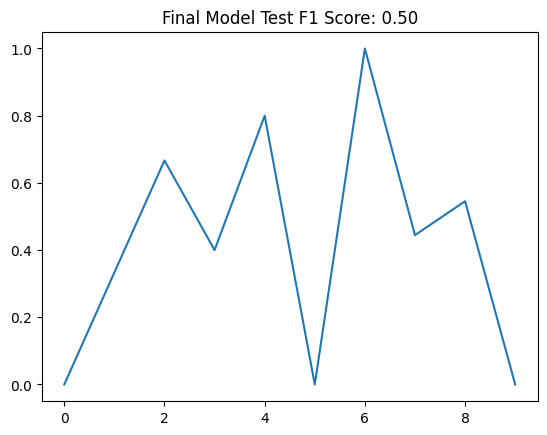

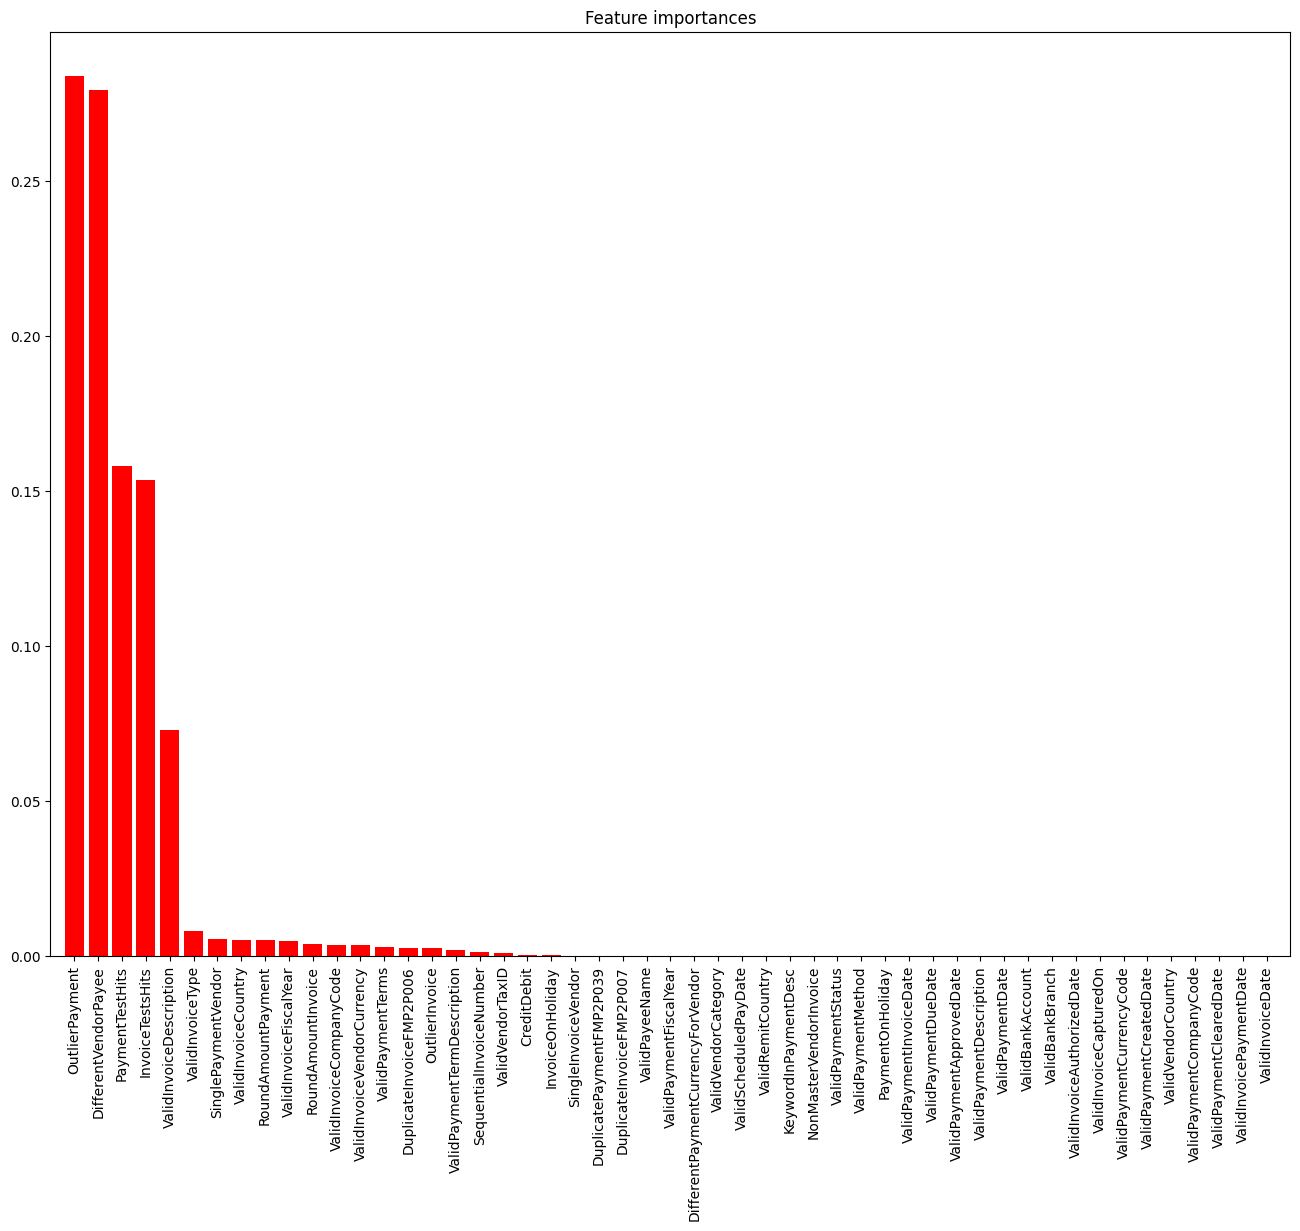

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the number of iterations
n_iterations = 10  # You can adjust this number as needed

# Lists to store results
f1_results = []

# Iterate over multiple runs
for iteration in range(n_iterations):
    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=iteration)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=iteration)

    # Initialize and train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=iteration)
    clf.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = clf.predict(X_validation)

    # Evaluate the model's score on the validation set
    f1_result = f1_score(y_validation, y_pred)
    f1_results.append(f1_result)
    # print(f"Iteration {iteration + 1}: Validation F1 Score = {f1_result}")

# Calculate and print the average and standard deviation of the validation accuracies
avg_f1 = np.mean(f1_results)
std_f1 = np.std(f1_results)
print(f"Average Validation F1 Score: {avg_f1:.2f}")
print(f"Standard Deviation of Validation F1 Score: {std_f1:.2f}")

# Train the final model on the combined training and validation sets
X_train_final = np.concatenate((X_train, X_validation))
y_train_final = np.concatenate((y_train, y_validation))
final_model = RandomForestClassifier(n_estimators=100, random_state=0)  # You can use a random_state of your choice
final_model.fit(X_train_final, y_train_final)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
plt.title(f"Final Model Test F1 Score: {test_f1:.2f}")

# print a graph of f1 by iteration
plt.plot(f1_results)

# print feature importance
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

# Plot the feature importances of the forest
plt.figure(figsize=(16, 12))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

[[514   3]
 [  3   3]]
[[0.98279159 0.00573614]
 [0.00573614 0.00573614]]


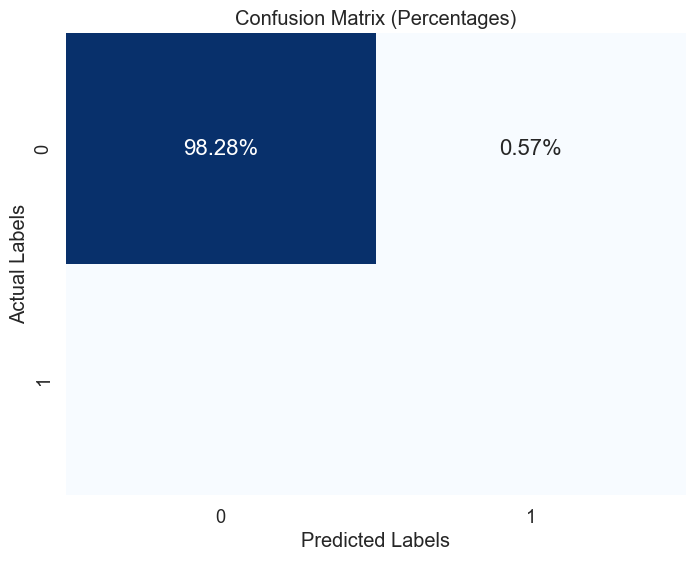

In [14]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# print as a good looking table
def print_confusion_matrix(y_true, y_pred):
    # print confusion matrix actual records
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print(cm)

    # Create a heatmap for visualization using seaborn
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font size if needed
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 16}, cbar=False)

    # Set axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix (Percentages)')

    # Show the plot
    plt.show()

print_confusion_matrix(y_test, y_pred_test)




Area under ROC curve: 0.99


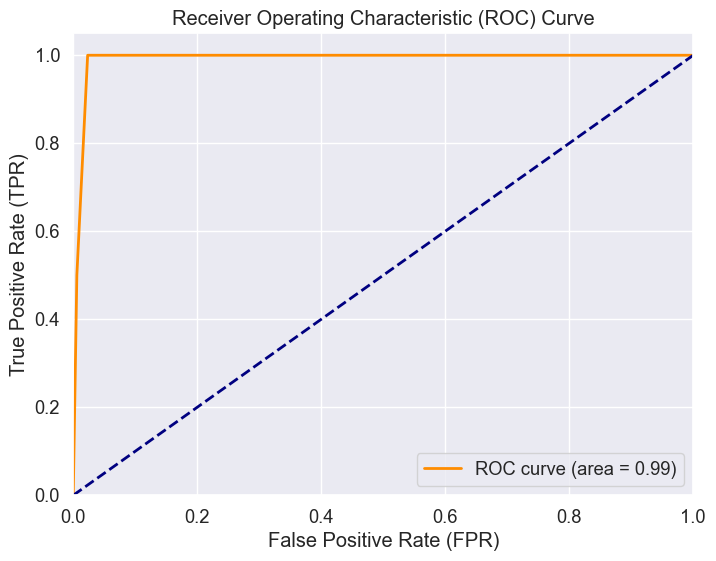

In [15]:
# print ROC curve
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(f"Area under ROC curve: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

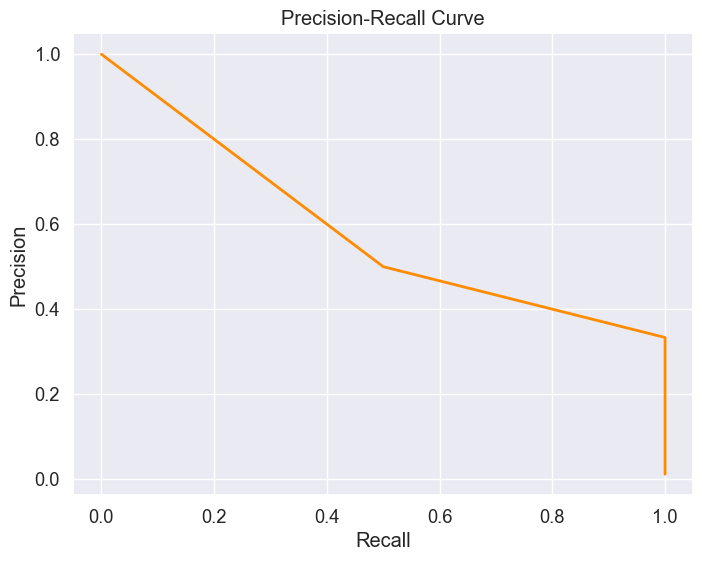

In [16]:
# print precision recall curve
from sklearn.metrics import precision_recall_curve

# Get the predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]

# Create the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [17]:
# print classification report
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.50      0.50      0.50         6

    accuracy                           0.99       523
   macro avg       0.75      0.75      0.75       523
weighted avg       0.99      0.99      0.99       523



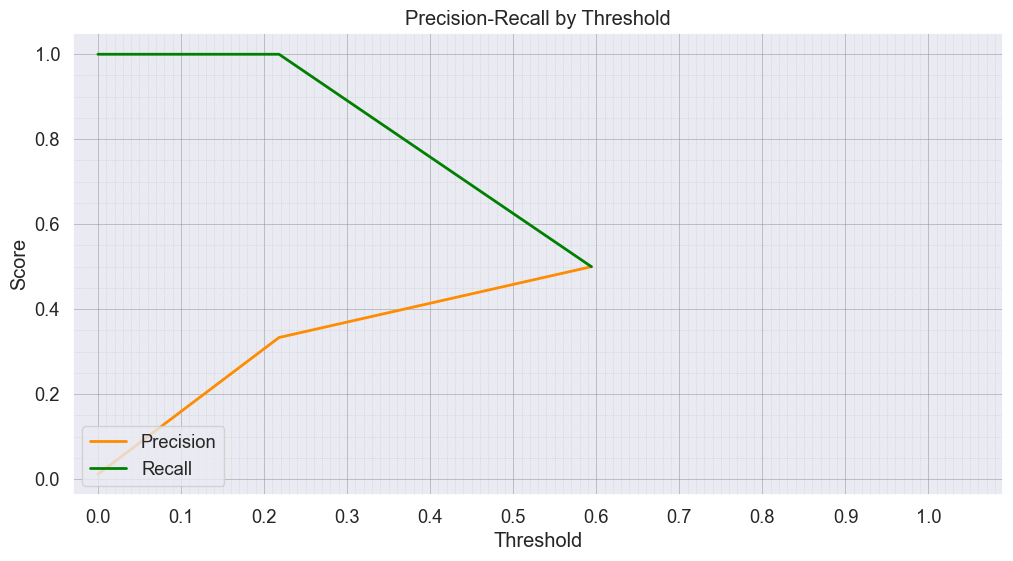

In [18]:
# print precision recall by threshold
from sklearn.metrics import precision_recall_curve

# Get the predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]

# Create the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)


# Plot the precision-recall curve
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision[:-1], color='darkorange', lw=2, label='Precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall by Threshold')
plt.legend(loc='lower left')

# Set major ticks at intervals of 0.1
plt.xticks(np.arange(0, 1.1, 0.1))

# Set minor ticks at intervals of 0.05
plt.minorticks_on()
plt.xticks(np.arange(0, 1.1, 0.01), minor=True)



# Enable grid lines for major and minor ticks
plt.grid(which='both', linestyle='-', linewidth=0.5, color='gray', alpha=0.6)

# Customize the appearance of major and minor grid lines (optional)
plt.grid(which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.6)
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.3)

plt.show()

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from IPython.display import HTML
from sklearn.metrics import confusion_matrix

# Create a Random Forest classifier (you can adjust hyperparameters as needed)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get predicted probabilities for the positive class (class 1)
y_pred_probs = clf.predict_proba(X_test)[:, 1]

# create a range with increment of .01
thresholds = np.arange(.2, .8, 0.01)

# iterate through the thresholds and calculate precision and recall and f1
scores = []
for threshold in thresholds:
    y_pred = (y_pred_probs >= threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp * 1.0 / (fp + tn)  # False Positive Rate
    fnr = fn * 1.0 / (fn + tp)  # False Negative Rate
    tpr = tp * 1.0 / (tp + fn)  # True Positive Rate (Sensitivity)
    tnr = tn * 1.0 / (tn + fp)  # True Negative Rate (Specificity)



    custom_metric = recall * 1 + f1 * .8 + precision * .6

    scores.append((threshold, precision, recall, f1, fpr, fnr, tpr, tnr, custom_metric))
    # create a dataframe
    scores_df = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1', 'fpr', 'fnr', 'tpr', 'tnr', 'custom_metric'])

# find the best threshold
# find highest custom metric
highest_custom_metric = np.max(scores_df['custom_metric'])
# filter array for highest custom metric
filtered_scores = scores_df[scores_df['custom_metric'] == highest_custom_metric]['threshold'].values
# get highest threshold
best_threshold = np.max(filtered_scores)

print(f"Best Threshold: {best_threshold:.2f}")

HTML(scores_df.to_html())

Best Threshold: 0.23


,threshold,precision,recall,f1,fpr,fnr,tpr,tnr,custom_metric
0,0.20,0.33,1.00,0.50,0.02,0.00,1.00,0.98,1.60
1,0.21,0.33,1.00,0.50,0.02,0.00,1.00,0.98,1.60
2,0.22,0.33,1.00,0.50,0.02,0.00,1.00,0.98,1.60
3,0.23,0.33,1.00,0.50,0.02,0.00,1.00,0.98,1.60
4,0.24,0.50,0.50,0.50,0.01,0.50,0.50,0.99,1.20
5,0.25,0.50,0.50,0.50,0.01,0.50,0.50,0.99,1.20
6,0.26,0.50,0.50,0.50,0.01,0.50,0.50,0.99,1.20
7,0.27,0.50,0.50,0.50,0.01,0.50,0.50,0.99,1.20
8,0.28,0.50,0.50,0.50,0.01,0.50,0.50,0.99,1.20
9,0.29,0.50,0.50,0.50,0.01,0.50,0.50,0.99,1.20


In [20]:
# Provide values of the metrics for best threshold
y_pred = (y_pred_probs >= best_threshold).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"Area under ROC curve: {roc_auc:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
cmatrix = {
    'tn': tn,
    'fp': fp,
    'fn': fn,
    'tp': tp
}
print(cmatrix)

conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')
tn, fp, fn, tp = conf_matrix.ravel()
tn, fp, fn, tp = round(tn*100, 2), round(fp*100, 2), round(fn*100, 2), round(tp*100, 2)
percent_cmatrix = {
    'tn': tn,
    'fp': fp,
    'fn': fn,
    'tp': tp
}
print(percent_cmatrix)


fpr = fp * 1.0 / (fp + tn)  # False Positive Rate
fnr = fn * 1.0 / (fn + tp)  # False Negative Rate
tpr = tp * 1.0 / (tp + fn)  # True Positive Rate (Sensitivity)
tnr = tn * 1.0 / (tn + fp)  # True Negative Rate (Specificity)

print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")
print(f"False Positive Rate: {fpr:.2%}")
print(f"False Negative Rate: {fnr:.2%}")
print(f"True Positive Rate (Sensitivity): {tpr:.2%}")
print(f"True Negative Rate (Specificity): {tnr:.2%}")

Area under ROC curve: 0.99
{'tn': 505, 'fp': 12, 'fn': 0, 'tp': 6}
{'tn': 96.56, 'fp': 2.29, 'fn': 0.0, 'tp': 1.15}
Precision: 33.33%
Recall: 100.00%
F1 Score: 50.00%
False Positive Rate: 2.32%
False Negative Rate: 0.00%
True Positive Rate (Sensitivity): 100.00%
True Negative Rate (Specificity): 97.68%


In [21]:
import os
import joblib
import uuid

# create feature name and feature importance tuple
feature_importance = list(zip(X.columns, final_model.feature_importances_))
created_date_time = datetime.datetime.now().strftime("%Y-%m-%d %H_%M_%S")



model_package = {
    'predictor': final_model,
    'decision_threshold': best_threshold,
    'input_columns': input_columns,
    'feature_importance': feature_importance,
    'created_date': created_date_time,
    'model_type': 'classification',
    'f1_score': f1,
    'roc_auc_score': roc_auc,
    'precision_score': precision,
    'recall_score': recall,
    "fpr": fpr, 
    "tpr": tpr,
    'fnr': fnr,
    'tnr': tnr,
    "model_id": str(uuid.uuid4()),
}

model_dir_path = r'C:\KonaAI ML\konaai_ml-3.2.5\code\src\assets'
model_file_name = 'p2p_single_udm.bin'
model_path = joblib.dump(model_package, os.path.join(model_dir_path, model_file_name))[0]
model_path

'C:\\KonaAI ML\\konaai_ml-3.2.5\\code\\src\\assets\\p2p_single_udm.bin'

In [22]:
model = joblib.load(model_path)
model

{'predictor': RandomForestClassifier(random_state=0),
 'decision_threshold': 0.23000000000000004,
 'input_columns': ['FMP2P001',
  'InvoiceDescription',
  'PaymentTerms',
  'InvoiceVendorCurrency',
  'FMP2P006',
  'FMP2P014',
  'InvoiceDebitOrCreditIndicator',
  'PaymentDate',
  'PaymentMethod',
  'VendorTaxID',
  'InvoiceAuthorizedDate',
  'PaymentInvoiceDate',
  'FMP2P029',
  'INV_Tests_Failed_Count',
  'InvoicePaymentDate',
  'TestsFailedCount',
  'FMP2P032',
  'BankBranch',
  'PaymentCompanyCode',
  'PaymentDescription',
  'VendorCountry',
  'FMP2P026',
  'PMT_SPT_PayeeName',
  'PaymentStatus',
  'ScheduledPayDate',
  'InvoiceCountry',
  'InvoiceDate',
  'FMP2P007',
  'RemitCountry',
  'FMP2P039',
  'FMP2P018',
  'PayeeName',
  'PaymentCreatedDate',
  'PaymentCurrencyCode',
  'FMP2P012',
  'BankAccount',
  'FMP2P033',
  'VendorCategory',
  'PaymentApprovedDate',
  'FMP2P040',
  'PaymentFiscalYear',
  'FMP2P022',
  'InvoiceFiscalYear',
  'PaymentClearedDate',
  'PaymentTermDescripti

In [28]:
feature_importance = model.get('feature_importance')
feature_importance = [(feature, importance) for feature, importance in feature_importance if importance > 0]
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance = {feature:importance for feature, importance in feature_importance}
feature_importance

{'OutlierPayment': 0.2840562434152958,
 'DifferentVendorPayee': 0.2795234177946385,
 'PaymentTestHits': 0.15808593652179745,
 'InvoiceTestsHits': 0.15367399858273242,
 'ValidInvoiceDescription': 0.07283826050049681,
 'ValidInvoiceType': 0.008015983715934049,
 'SinglePaymentVendor': 0.005408190263127617,
 'ValidInvoiceCountry': 0.005185423238020036,
 'RoundAmountPayment': 0.005150192176371511,
 'ValidInvoiceFiscalYear': 0.004814615928694846,
 'RoundAmountInvoice': 0.003848240885666901,
 'ValidInvoiceCompanyCode': 0.0035271433800528494,
 'ValidInvoiceVendorCurrency': 0.003476786866812873,
 'ValidPaymentTerms': 0.0028892355541691407,
 'DuplicateInvoiceFMP2P006': 0.0025120739497961246,
 'OutlierInvoice': 0.00251206651432842,
 'ValidPaymentTermDescription': 0.0018052278543622788,
 'SequentialInvoiceNumber': 0.0011108549052172986,
 'ValidVendorTaxID': 0.0010570224641946605,
 'CreditDebit': 0.00019807457861006537,
 'InvoiceOnHoliday': 0.0001954799433258496,
 'SingleInvoiceVendor': 5.794674051